# 1. Préliminaires

## 1.1. Importations

Importons les bibliothèques :

In [1]:
# Data
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import MinMaxScaler

# K-means
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# CAH
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# KNN
from sklearn.neighbors import NearestNeighbors

# DBSCAN
from sklearn.cluster import DBSCAN

# Silhouette score
from sklearn.metrics import silhouette_score

Chargeons les données :

In [2]:
df = pd.read_csv('RFM_data.csv')

## 1.2. Présentation des données

Forme du tableau :

In [3]:
df.shape

(91592, 4)

Tête du tableau (5 premières lignes) :

In [4]:
df.head()

,recency,frequency,monetary,review_score
0,111,1,141.90,5.0
1,114,1,27.19,4.0
2,536,1,86.22,3.0
3,320,1,43.62,4.0
4,287,1,196.89,5.0


## 1.3. Standardisation

In [5]:
# Scaler
scaler = MinMaxScaler()

# Standardisation des données
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.describe().round(2)

,recency,frequency,monetary,review_score
count,91592.00,91592.00,91592.00,91592.00
mean,0.34,0.00,0.14,0.79
std,0.22,0.01,0.14,0.32
min,0.00,0.00,0.00,0.00
25%,0.16,0.00,0.05,0.75
50%,0.31,0.00,0.10,1.00
75%,0.50,0.00,0.17,1.00
max,1.00,1.00,1.00,1.00


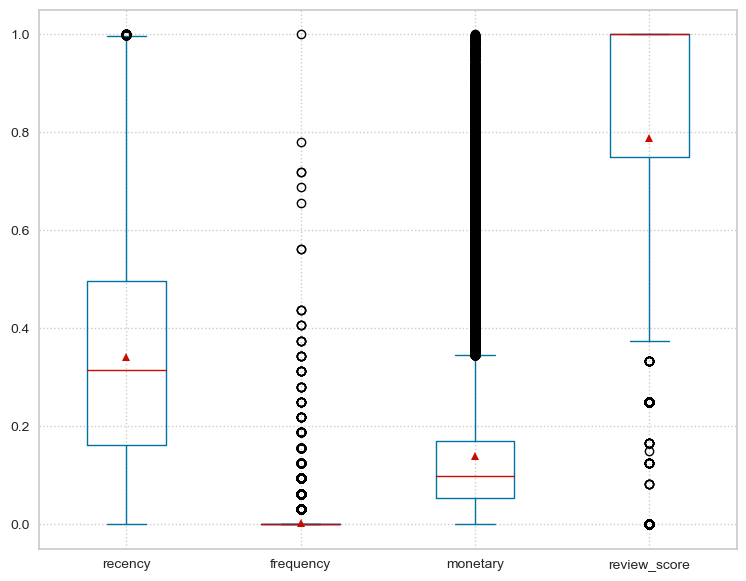

In [6]:
df_scaled.plot(kind='box', figsize=(9, 7), showmeans=True)
plt.grid(linestyle=':')
plt.show()

Comme nous pouvons le voir, les 4 variables s'étendent de 0 à 1. En effet, les données ont été standardisées par l'algorithme MinMax dans le but de faciliter l'apprentissage des algorithmes de clusterings qui utilisent des distances euclidiennes.

Tout d'abord, ces algorithmes vont nous permettre de réaliser une segmentation RFM. Ensuite, après avoir choisi l'algorithme le plus performant, nous effectuerons une segmentation prenant en compte la satisfaction des clients (en plus des dimensions RFM).

In [7]:
df_rfm = df_scaled.drop(labels='review_score', axis=1)
df_rfm.shape

(91592, 3)

Le tableau `df_rfm` contient uniquement les dimensions RFM (c'est-à-dire les variables "recency", "frequency" et "monetary").

# 2. Clustering

Nous essaierons 3 algorithmes de clustering qui sont le k-means, la CAH (Classification Ascendante Hiérarchique) et le DBSCAN (Density-Based Spatial Clustering of Applications with Noise). Pour chaque algorithme, on notera la moyenne du coefficient de silhouette pour tous les points. Ce coefficient est une mesure de la qualité de partitionnement. Enfin, créons un tableau dans lequel nous inscrirons ces coefficients :

In [8]:
score_ser = pd.Series(name='silhouette score', dtype='float64')

## 2.1. K-Means

Pour choisir le nombre optimal de k clusters, nous allons lancer le k-means plusieurs fois avec différentes valeurs de k. A chaque k-means, nous allons relever l'inertie intraclasse. Ensuite, nous représenterons graphiquement l'inertie intraclasse en fonction du nombre k de clusters. Enfin, sur la courbe obtenue, nous déterminerons le "coude" qui nous indiquera le nombre k de clusters à retenir.

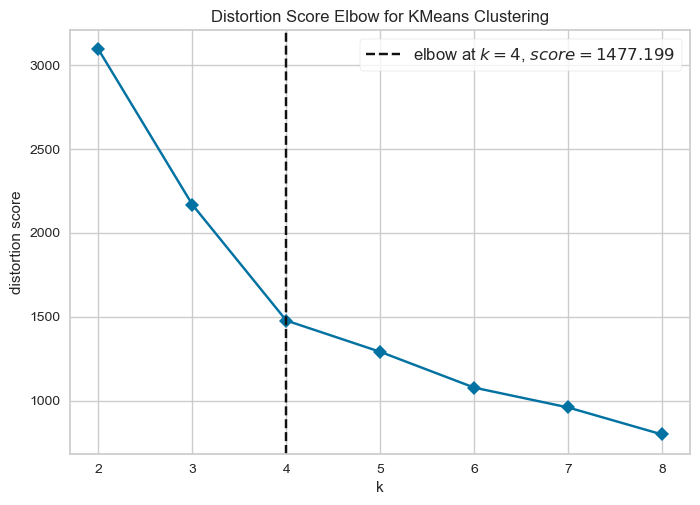

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# k-means
kmeans = KMeans(init='k-means++', n_init='auto', random_state=1)

# Visualiseur de l'inertie du k-means pour chaque nombre k allant de 2 à 9 (non inclus)
visualizer = KElbowVisualizer(kmeans, k=(2, 9), timings=False)

# Entraînement du visualiseur
visualizer.fit(df_rfm)

# Enregistrement du nombre k de clusters pour lequel on observe un coude
k = visualizer.elbow_value_

# Affichage de la figure
visualizer.show()

Nous observons un coude pour un nombre de 4 clusters. Nous allons donc instancier un k-means avec un nombre de clusters k égal à 4 :

In [10]:
# k-means pour k clusters
kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=1)

Le visualiseur de silhouette de la bibliothèque `Yellowbrick` permet d'afficher le coefficient de silhouette de chaque individu par cluster. Il permet notamment d'examiner la densité et l'homogénéité des clusters. Le coefficient de silhouette varie entre -1 et 1. Lorsque le coefficient est proche de 1, cela indique que l'individu a correctement été assigné à son cluster. Au contraire, lorsque le coefficient est proche de -1, cela suggère que l'individu a été affecté au mauvais cluster.

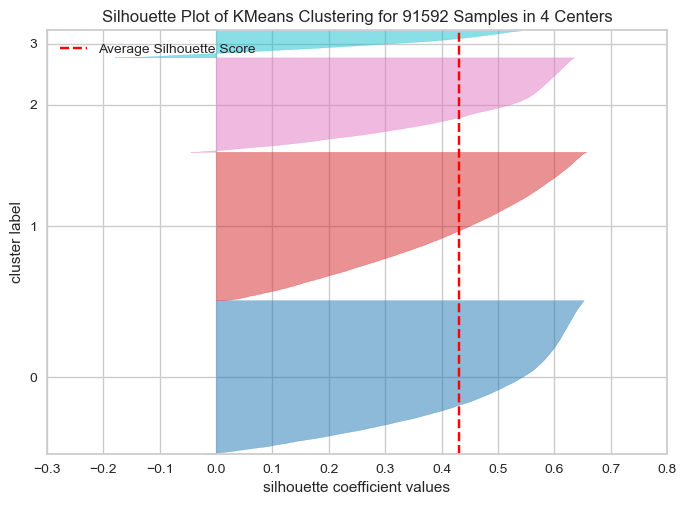

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91592 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
# Visualiseur de silhouette
visualizer = SilhouetteVisualizer(kmeans, colors='tab10')

# Entraînement du visualiseur
visualizer.fit(df_rfm)

# Enregistrement du coefficient de silhouette moyen
score_ser.loc['K-Means'] = visualizer.silhouette_score_

# Affichage de la figure
visualizer.show()

In [12]:
# Affichage du coefficient de silhouette moyen
score_ser['K-Means'].round(2)

0.43

Le coefficient de silhouette moyen indique que dans l'ensemble individus ont assez bien été affectés aux bons clusters. Cependant, on remarque que les clusters 2 et 3 ont des points ayant un coefficient de silhouette négatif. Ces points sont donc plutôt mal classés. D'ailleurs, on note aussi que le cluster 3 est nettement plus petit que les autres.

Désormais, intéressons aux distances entre les clusters :

C:\Users\mauri\.conda\envs\pro5\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\mauri\.conda\envs\pro5\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


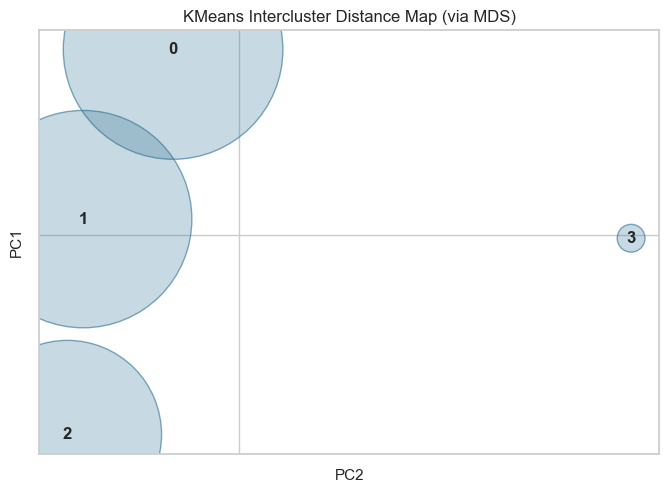

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [13]:
# Visualiseur de distances interclusters
visualizer = InterclusterDistance(kmeans, random_state=1, legend=False)

# Entraînement du visualiseur
visualizer.fit(df_rfm)

# Affichage de la figure
visualizer.show()

On voit que le cluster 3 est relativement très éloigné des autres clusters.

In [14]:
# Entraînement du k-means
kmeans.fit(df_rfm)

# Enregistrement des centroïdes
centroids = kmeans.cluster_centers_

# Enregistrement des clusters
clusters = kmeans.labels_
clusters = pd.Series(clusters, name='clusters')

# Création d'un DataFrame en concaténant le tablau RFM et la colonne "clusters"
df_clusters = pd.concat([df_rfm, clusters], axis=1)

df_clusters.head().round(2)

,recency,frequency,monetary,clusters
0,0.16,0.0,0.13,0
1,0.16,0.0,0.02,0
2,0.77,0.0,0.08,2
3,0.46,0.0,0.03,1
4,0.41,0.0,0.19,1


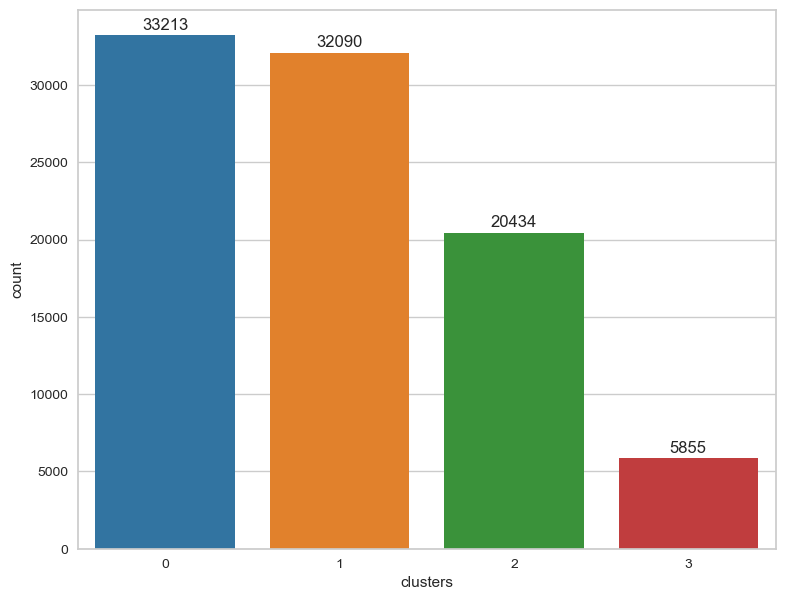

In [15]:
# Taille de la figure
fig, ax = plt.subplots(figsize=(9, 7))

# Bar plot des effectifs de chaque cluster
barplot = sns.countplot(data=df_clusters, x='clusters', palette='tab10', ax=ax)

# Ajout des valeurs des effectifs aux extrémités des barres
barplot.bar_label(ax.containers[0], label_type='edge', padding=2)

# Affichage
plt.show()

Les clusters 0 et 1 ont des tailles très similaires. Le cluster 0 est le plus grand, alors que le cluster 3 est le plus petit.

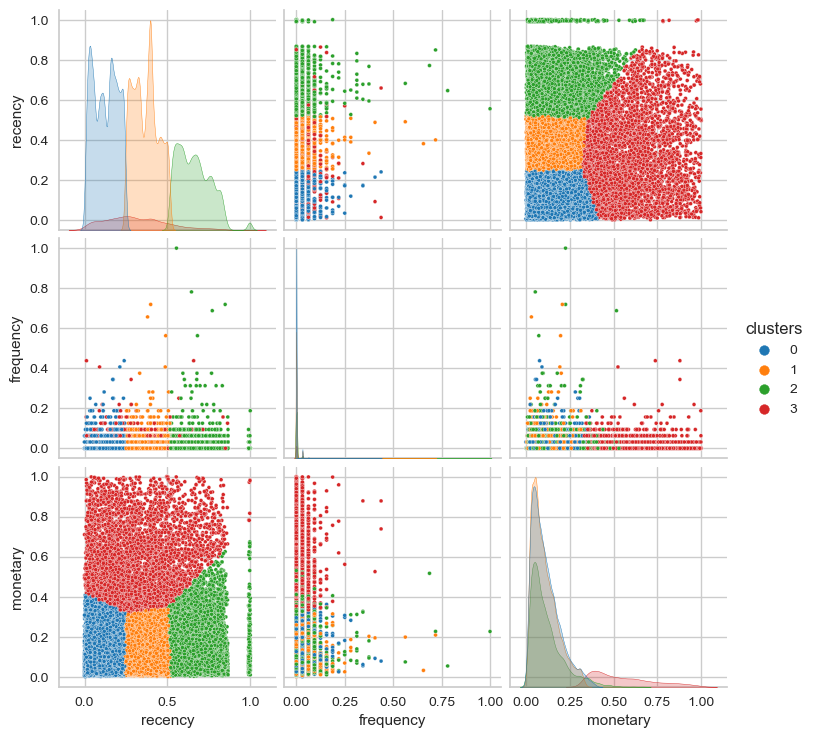

In [16]:
sns.pairplot(df_clusters, hue='clusters', palette='tab10', plot_kws={'s': 8})
plt.show()

Il semble que les features les plus importantes dans ce clustering soient "recency" et "monetary". Nos clusters peuvent donc être décrits de la manière suivante :
> **0** Clients récents à faible dépense

> **1** Clients modérément récents à faible dépense

> **2** Clients anciens à dépense faible ou modérée

> **3** Clients à forte dépense

Enfin, analysons les individus moyens (centroïdes) de chaque cluster à l'aide d'un diagramme en radar :

In [17]:
def radar_plot(features, centroids, figsize):
    """
    Affiche un radar plot.

    Positional arguments :
    -------------------------------------
    features : list : Liste des noms des features.
    centoids : list : Liste des centroïdes. Chaque centroïde est représenté par une liste de valeurs pour chaque feature.
    figsize : tuple : Largeur, hauteur en pouces.
    """
    # Création de copies
    feat_list = features.copy()
    cen_list = centroids.copy()

    # Calcul des angles entre chaque axe
    angles = np.linspace(0, 2*np.pi, len(feat_list), endpoint=False)

    # Ajout du premier angle au bout de la liste pour décrire un cercle
    angles = np.concatenate((angles, [angles[0]]))

    # Même raisonnement pour les noms des features
    feat_list.append(feat_list[0])

    # Même raisonnement pour les centroïdes
    for i in range(len(cen_list)):
        cen_list[i].append(cen_list[i][0])

    # Taille de la figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)

    # Colormap
    cmap = plt.get_cmap('tab10')

    # Radar plot
    for i in range(len(cen_list)):
        # Centroïde du cluster i
        ax.plot(angles, cen_list[i], 'o-',
                color=cmap(i), linewidth=1, label=str(i))
        ax.fill(angles, cen_list[i], alpha=0.05, color=cmap(i))

    # Label, grille, espacement, légende et affichage
    ax.set_thetagrids(angles * 180/np.pi, feat_list)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

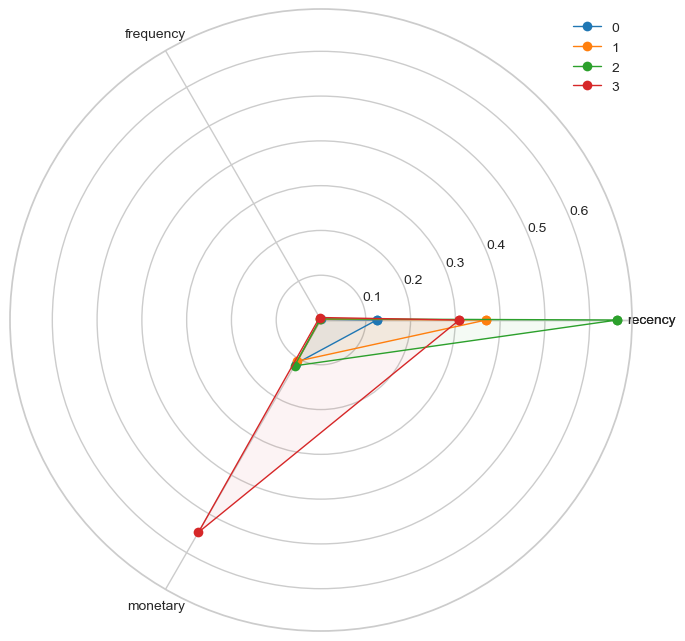

In [18]:
# Liste des noms des features
features = list(df_rfm.columns)

# Liste des centroïdes
centroids = centroids.tolist()

radar_plot(features=features, centroids=centroids, figsize=(7, 7))

Effectivement, la fréquence a un rôle négligeable dans ce clustering.

## 2.2. CAH

Ici, nous allons appliquer une CAH (Classification Ascendante Hiérarchique) également appelé clustering agglomératif. Or, c'est un algorithme dont la complexité est lourde. En effet, le temps de calcul et l'espace mémoire nécessaires sont importants. Il nous faut donc réduire notre nombre d'individus car nous en avons plus de 91 000. Pour cela, nous pouvons créer un échantillon de 1 000 individus par tirage aléatoire (sans remise).

In [19]:
df_sample = df.sample(n=1000, random_state=1)
df_sample = df_sample.drop(labels='review_score', axis=1)
df_sample.shape

(1000, 3)

Standardisons notre échantillon à l'aide d'un algorithme MinMax :

In [20]:
# Standardisation des données
df_sample = scaler.fit_transform(df_sample)
df_sample = pd.DataFrame(df_sample, columns=df_rfm.columns)

df_sample.describe().round(2)

,recency,frequency,monetary
count,1000.00,1000.00,1000.00
mean,0.34,0.01,0.13
std,0.22,0.06,0.13
min,0.00,0.00,0.00
25%,0.17,0.00,0.04
50%,0.31,0.00,0.09
75%,0.50,0.00,0.16
max,1.00,1.00,1.00


Maintenant que nous avons notre échantillon, nous pouvons appliquer la CAH.

In [21]:
# Classification Ascendante Hiérarchique
cah = AgglomerativeClustering(
    n_clusters=4, linkage='ward', compute_distances=True)

# Entraînement de la CAH
cah.fit(df_sample)

# Enregistrement des clusters
clusters = cah.labels_
clusters = pd.Series(clusters, name='clusters', index=df_sample.index)

# Création d'un DataFrame en concaténant le tablau RFM et la colonne "clusters"
df_clusters = pd.concat([df_sample, clusters], axis=1)

# Enregistrement du coefficient de silhouette moyen
score_ser.loc['CAH'] = silhouette_score(
    df_sample, clusters, metric='euclidean')

# Affichage du coefficient de silhouette moyen
score_ser['CAH'].round(2)

0.36

Le coefficient de silhouette moyen positif indique que les points sont en moyenne bien classés.

Regardons la taille de chaque cluster :

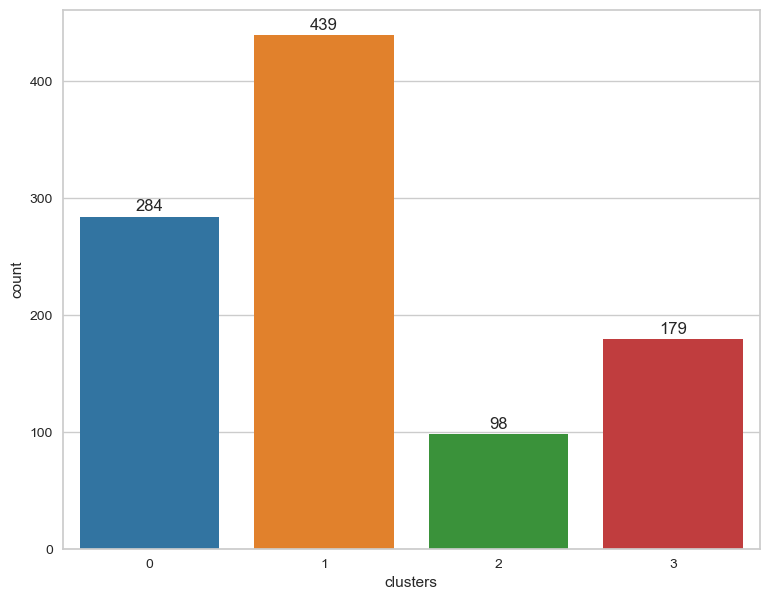

In [22]:
# Taille de la figure
fig, ax = plt.subplots(figsize=(9, 7))

# Bar plot des effectifs de chaque cluster
barplot = sns.countplot(data=df_clusters, x='clusters', palette='tab10', ax=ax)

# Ajout des valeurs des effectifs aux extrémités des barres
barplot.bar_label(ax.containers[0], label_type='edge', padding=2)

# Affichage
plt.show()

Le plus grand est le cluster 1, tandis que le plus petit est le cluster 2.

Regardons le dendrogramme de cette CAH grâce à cette fonction issue de la [documentation de scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) :

In [23]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

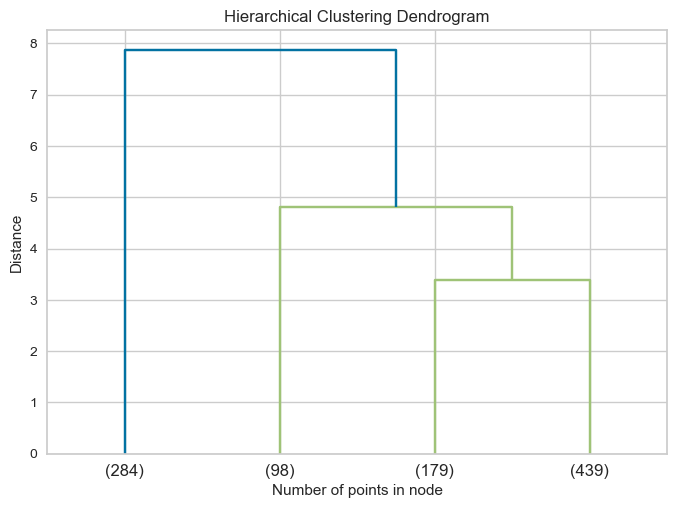

In [24]:
# Dendrogramme à 4 clusters
plot_dendrogram(model=cah, p=4, truncate_mode='lastp')

# Titre, labels et affichage
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.xlabel('Number of points in node')
plt.show()

Le dendrogramme nous permet d'avoir une idée des distances entre les clusters. Par exemple, ici nous pouvons observer que les clusters 1 et 3 peuvent être regroupés lorsque la distance est supérieure à 3.3 environ.

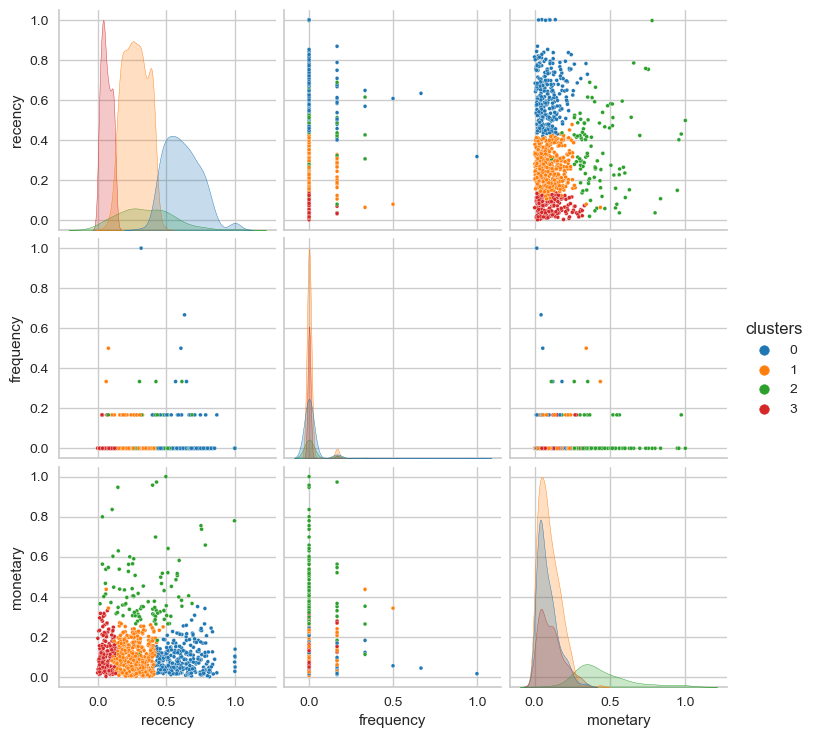

In [25]:
sns.pairplot(df_clusters, hue='clusters', palette='tab10', plot_kws={'s': 8})
plt.show()

De nouveau, les variables "recency" et "monetary" ont l'air d'être les plus importantes dans le clustering. Ainsi, nos clusters peuvent être décrits comme :

> **0** Clients anciens à faible dépense

> **1** Clients modérément récents à faible dépense

> **2** Clients à forte dépense

> **3** Clients récents à faible dépense

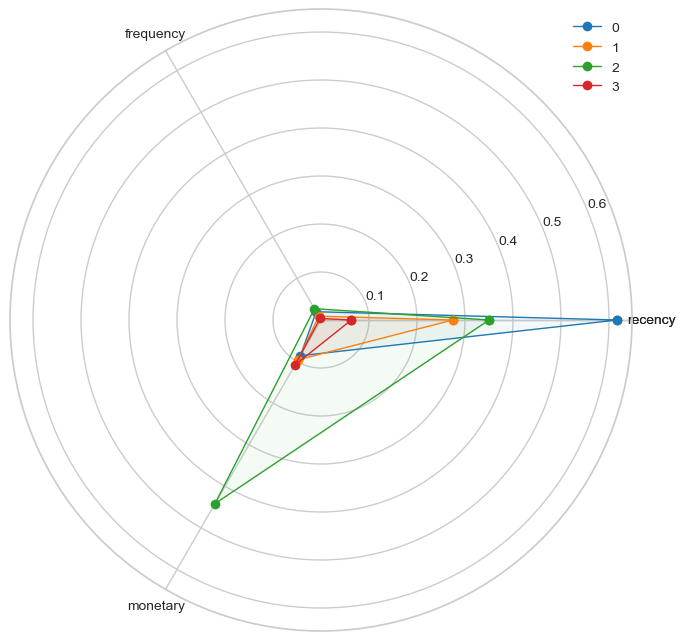

In [26]:
# Liste des centroïdes
centroids = df_clusters.groupby('clusters').apply('mean')
centroids = centroids.values.tolist()

radar_plot(features=features, centroids=centroids, figsize=(7, 7))

En examinant les individus moyens (centroïdes) de chaque cluster, on s'aperçoit qu'effectivement la fréquence à peu d'importance dans ce clustering. 

## 2.3. DBSCAN

Pour pouvoir comparer la qualité de partitionnement du DBSCAN avec les algorithmes précédents, nous aimerions également obtenir 4 clusters. Or, le DBSCAN ne possède pas d'hyperparamètre représentant directement le nombre de clusters. Il va donc nous falloir trouver des valeurs permettant d'avoir 4 clusters pour les hyperparamètres suivants :
- eps : _La distance maximale entre 2 points pour que l'un soit considéré comme voisin de l'autre._
- min_samples : _Le nombre minimum de points dans un rayon "eps" pour qu'un point soit considéré comme un point central. Le point lui-même est inclus._

Pour nous aider à fixer "eps", nous pouvons utiliser un k-NN (k plus proches voisins). En arrangeant les distances issues du k-NN par ordre croissant sur un graphique, nous pourrons observer un "coude". La distance correspondant à ce coude nous donnera une idée de la valeur d'"eps" à choisir.

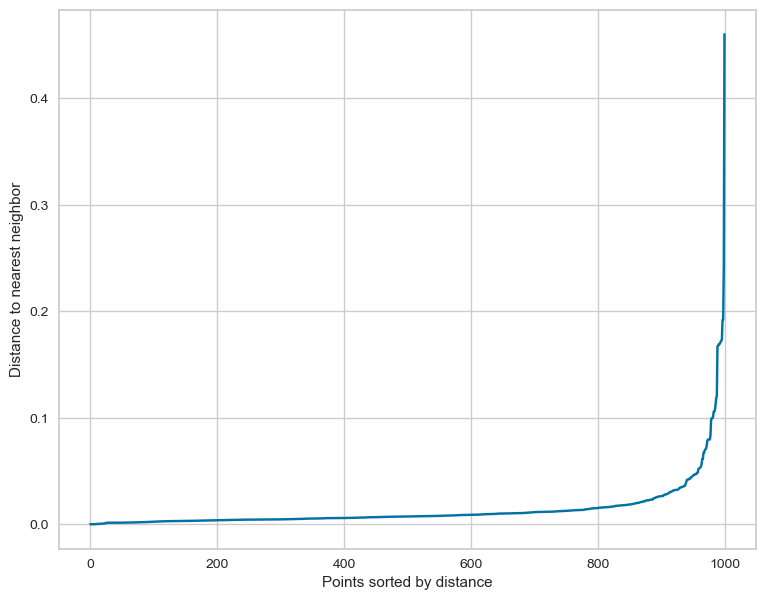

In [27]:
# k plus proche voisins
nn = NearestNeighbors(n_neighbors=2)

# Entraînement du k-NN
nn.fit(df_sample)

# Enregistrement des distances euclidiennes et des indices des points
nn_dist, nn_ind = nn.kneighbors(df_sample)

# Arrangement des points par ordre croissant des distances
nn_dist = np.sort(nn_dist, axis=0)

# Amputation de la première colonne qui ne contient que la valeur 0
# Seules les distances sont conservées
nn_dist = nn_dist[:, 1]

# Taille de la figure
plt.figure(figsize=(9, 7))

# Line plot
plt.plot(nn_dist)

# Labels et affichage
plt.ylabel('Distance to nearest neighbor')
plt.xlabel('Points sorted by distance')
plt.show()

Un coude peut être observé aux alentours de 0.05, alors c'est la valeur que nous choisirons pour l'hyperparamètre "eps". En ce qui concerne l'hyperparamètre "min_samples", on essayera une valeur permettant d'obtenir 4 clusters suffisamment grands. Prenons par exemple une valeur de 60.

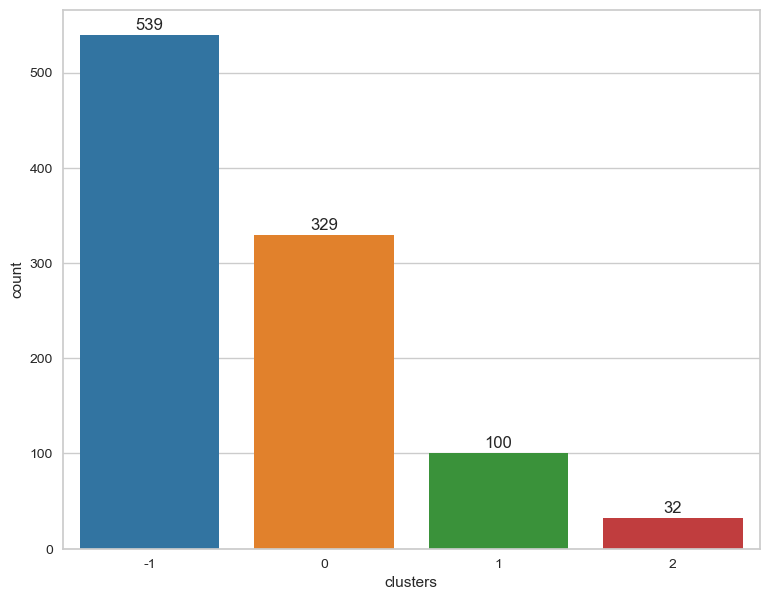

In [28]:
# Density-Based Spatial Clustering of Applications with Noise
dbscan = DBSCAN(eps=0.05, min_samples=60)

# Entraînement du DBSCAN
dbscan.fit(df_sample)

# Enregistrement des clusters
clusters = dbscan.labels_
clusters = pd.Series(clusters, name='clusters', index=df_sample.index)

# Création d'un DataFrame en concaténant le tablau RFM et la colonne "clusters"
df_clusters = pd.concat([df_sample, clusters], axis=1)

# Taille de la figure
fig, ax = plt.subplots(figsize=(9, 7))

# Bar plot des effectifs de chaque cluster
barplot = sns.countplot(data=df_clusters, x='clusters', palette='tab10', ax=ax)

# Ajout des valeurs des effectifs aux extrémités des barres
barplot.bar_label(ax.containers[0], label_type='edge', padding=2)

# Affichage
plt.show()

Les points qui sont considérés comme du bruit ont reçu le label -1. Cependant, dans notre cas, nous allons définir ces points comme un cluster. Par conséquent, nous avons bien 4 clusters. Le cluster -1 est le plus grand, alors que le plus petit est le cluster 2.

In [29]:
# Enregistrement du coefficient de silhouette moyen
score_ser.loc['DBSCAN'] = silhouette_score(
    df_sample, clusters, metric='euclidean')

# Affichage du coefficient de silhouette moyen
score_ser['DBSCAN'].round(2)

0.04

Le coefficient de silhouette moyen proche de 0 indique un chevauchement entre les clusters.

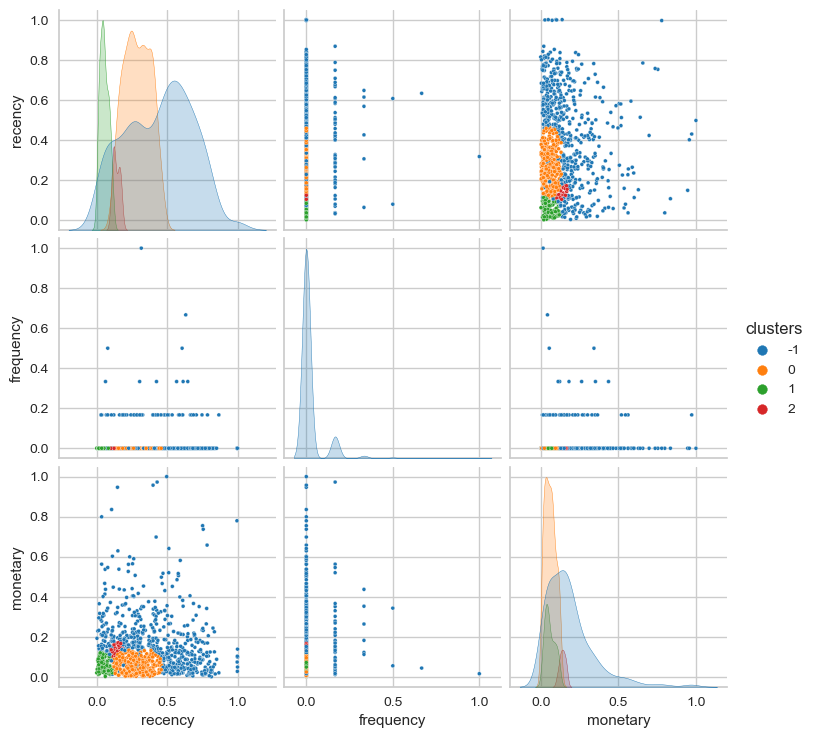

In [30]:
sns.pairplot(df_clusters, hue='clusters', palette='tab10', plot_kws={'s': 8})
plt.show()

Encore une fois, les variables "recency" et "monetary" semblent être les plus considérables pour le clustering. Nous allons décrire les clusters comme :

> **-1** Clients anciens ou récurrents ou à forte dépense

> **0** Clients modérément récents à faible dépense

> **1** Clients très récents à faible dépense

> **2** Clients récents à dépense modérée

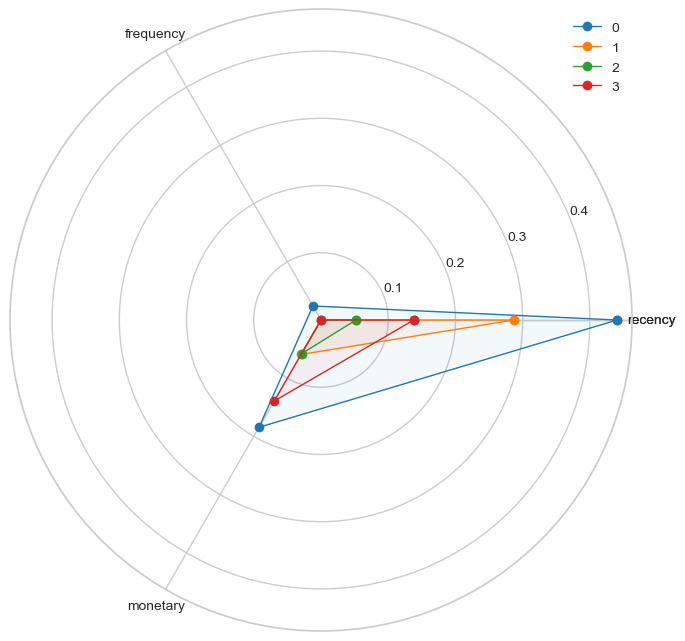

In [31]:
# Liste des centroïdes
centroids = df_clusters.groupby('clusters').apply('mean')
centroids = centroids.values.tolist()

radar_plot(features=features, centroids=centroids, figsize=(7, 7))

L'analyse des individus moyens (centroïdes) de chaque cluster nous indique que la fréquence semble n'avoir que de l'importance pour un seul cluster.

# 3. Choix du modèle

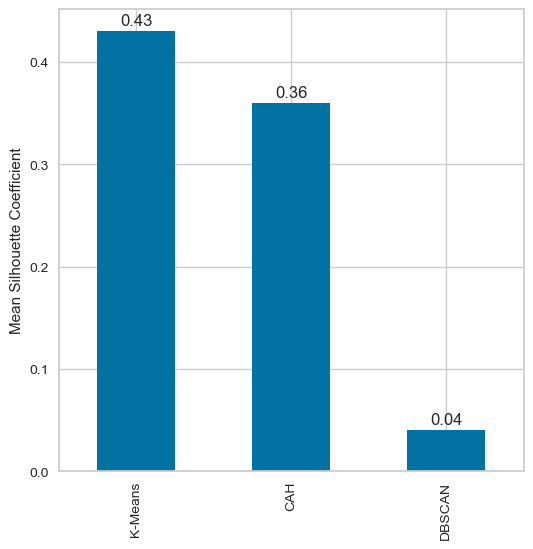

In [32]:
# Taille de la figure
fig, ax = plt.subplots(figsize=(6, 6))

# Bar plot des scores de silhouette arrondis au centième
barplot = score_ser.round(2).plot(kind='bar', ax=ax)

# Ajout des valeurs des effectifs aux extrémités des barres
barplot.bar_label(ax.containers[0], label_type='edge', padding=2)

# Label et affichage
plt.ylabel('Mean Silhouette Coefficient')
plt.show()

Nous constatons que le k-means a le coefficient de silhouette moyen le plus élevé parmi les 3 modèles que nous avons essayés. De plus, les clusters issus du k-means sont pertinents.

Par conséquent, nous allons entraîner un nouveau k-means en prenant en compte la satisfaction en plus des dimensions RFM.

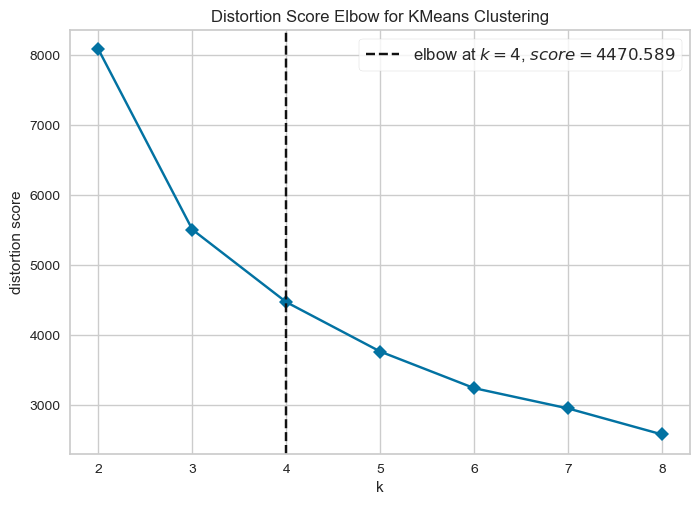

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
# k-means
kmeans = KMeans(init='k-means++', n_init='auto', random_state=1)

# Visualiseur de l'inertie du k-means pour chaque nombre k allant de 2 à 9 (non inclus)
visualizer = KElbowVisualizer(kmeans, k=(2, 9), timings=False)

# Entraînement du visualiseur
visualizer.fit(df_scaled)

# Enregistrement du nombre k de clusters pour lequel on observe un coude
k = visualizer.elbow_value_

# Affichage de la figure
visualizer.show()

Nous observons un coude pour un nombre de 4 clusters. Nous allons donc instancier un k-means avec un nombre de clusters k égal à 4 :

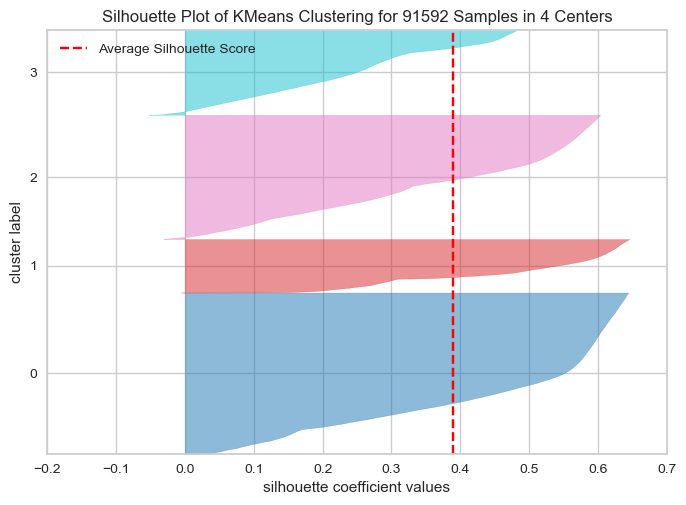

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91592 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
# k-means pour k clusters
kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=1)

# Visualiseur de silhouette
visualizer = SilhouetteVisualizer(kmeans, colors='tab10')

# Entraînement du visualiseur
visualizer.fit(df_scaled)

# Enregistrement du coefficient de silhouette moyen
silouette_coef = visualizer.silhouette_score_

# Affichage de la figure
visualizer.show()

In [35]:
# Affichage du coefficient de silhouette moyen
silouette_coef.round(2)

0.39

Le coefficient de silhouette moyen (positif) indique que dans l'ensemble individus ont bien été affectés aux bons clusters. Cependant, on remarque que les clusters 1, 2 et 3 ont quelques points ayant un coefficient de silhouette négatif. Ces points sont donc plutôt mal classés.

C:\Users\mauri\.conda\envs\pro5\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\mauri\.conda\envs\pro5\Lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
C:\Users\mauri\.conda\envs\pro5\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


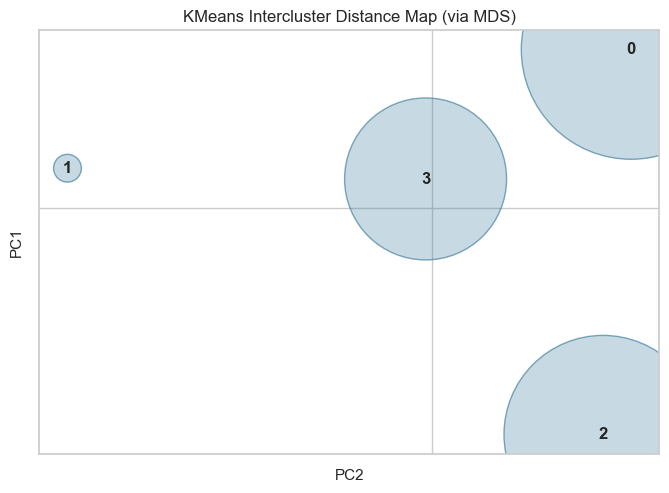

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [36]:
# Visualiseur de distances interclusters
visualizer = InterclusterDistance(kmeans, random_state=1, legend=False)

# Entraînement du visualiseur
visualizer.fit(df_scaled)

# Affichage de la figure
visualizer.show()

Les clusters 0 et 3 sont relativement proches. Au contraire, les clusters 1 et 2 sont respectivement éloignés des autres. Le cluster 1 est le plus isolé.

In [37]:
# Entraînement du k-means
kmeans.fit(df_scaled)

# Enregistrement des centroïdes
centroids = kmeans.cluster_centers_

# Enregistrement des clusters
clusters = kmeans.labels_
clusters = pd.Series(clusters, name='clusters')

# Création d'un DataFrame en concaténant les données d'entraînement et la colonne "clusters"
df_clusters = pd.concat([df_scaled, clusters], axis=1)

df_clusters.head().round(2)

,recency,frequency,monetary,review_score,clusters
0,0.16,0.0,0.13,1.00,0
1,0.16,0.0,0.02,0.75,3
2,0.77,0.0,0.08,0.50,3
3,0.46,0.0,0.03,0.75,3
4,0.41,0.0,0.19,1.00,2


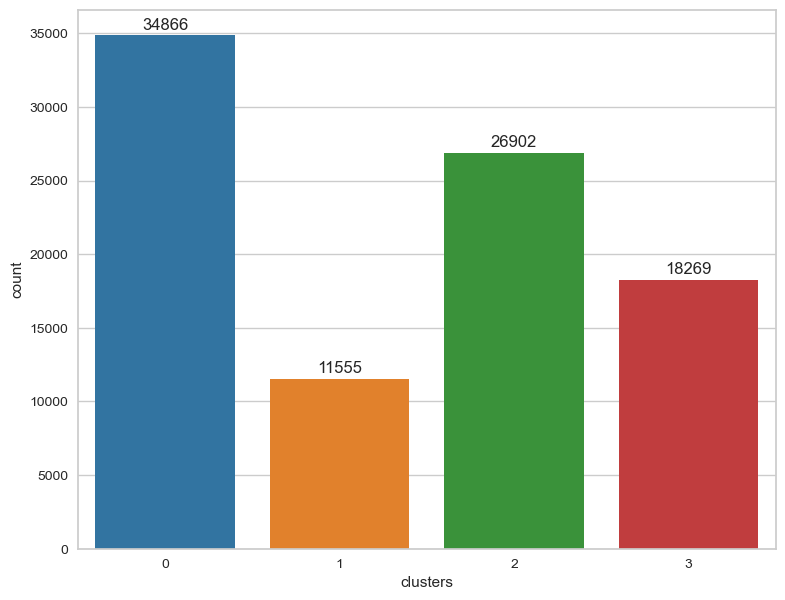

In [38]:
# Taille de la figure
fig, ax = plt.subplots(figsize=(9, 7))

# Bar plot des effectifs de chaque cluster
barplot = sns.countplot(data=df_clusters, x='clusters', palette='tab10', ax=ax)

# Ajout des valeurs des effectifs aux extrémités des barres
barplot.bar_label(ax.containers[0], label_type='edge', padding=2)

# Affichage
plt.show()

Les tailles entre les clusters sont inégales. Le plus grand est le cluster 0, tandis que le plus petit est le cluster 1.

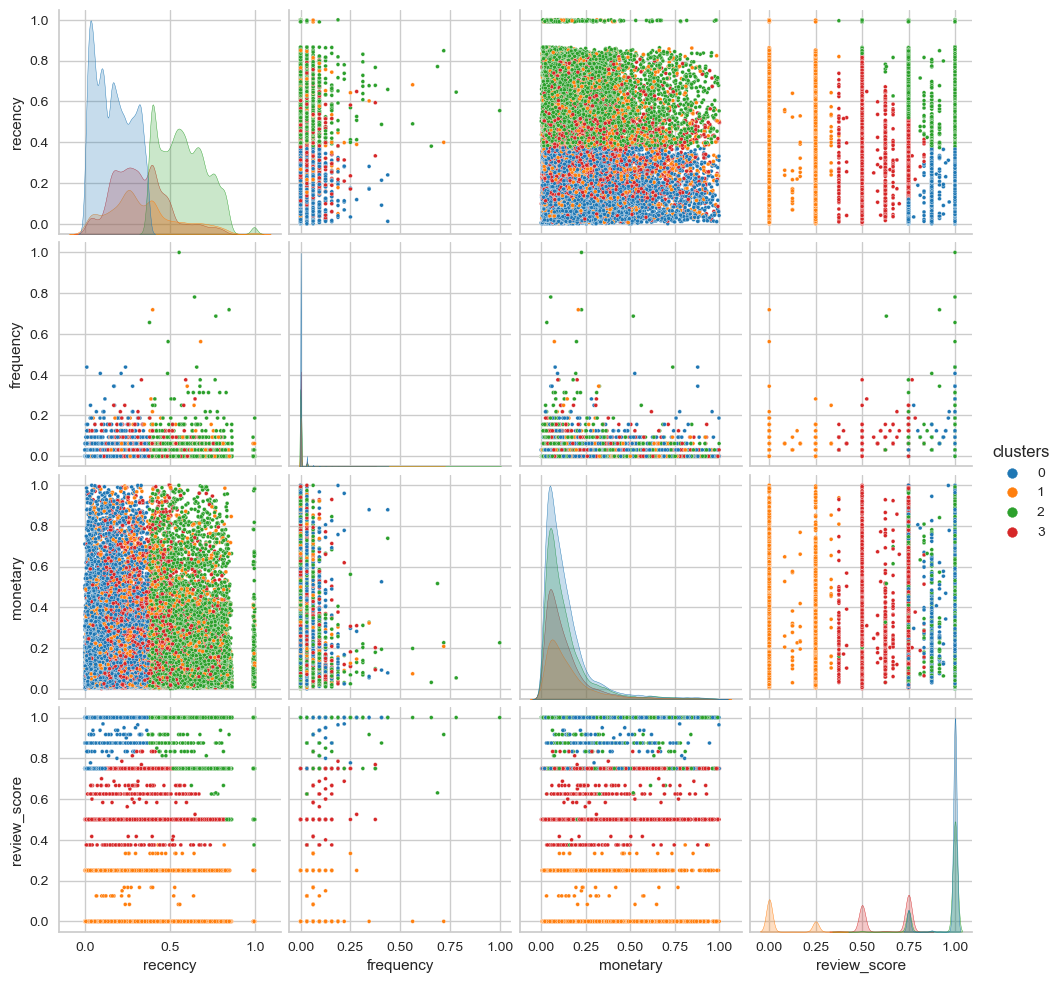

In [39]:
sns.pairplot(df_clusters, hue='clusters', palette='tab10', plot_kws={'s': 8})
plt.show()

Les variables "frequency" et "monetary" semblent avoir un impact négligeable dans ce clustering. Ainsi, nous allons interpréter les clusters comme :

> **0** Clients récents, très satisfaits

> **1** Clients mécontents

> **2** Clients anciens, modérément ou très satisfaits

> **3** Clients modérément satisfaits

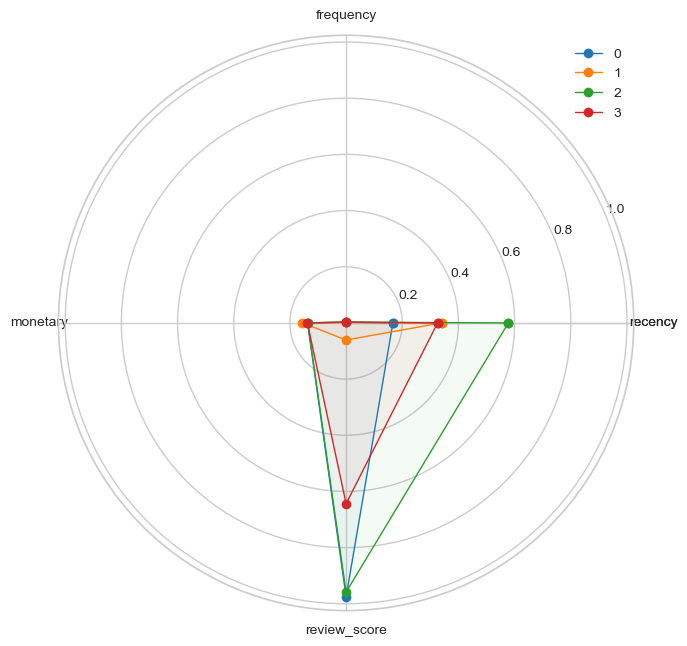

In [40]:
# Liste des noms des features
features = list(df.columns)

# Liste des centroïdes
centroids = centroids.tolist()

radar_plot(features=features, centroids=centroids, figsize=(7, 7))

L'examen des individus moyens (centroïdes) de chaque cluster suggèrent que la récence et la satisfaction sont les dimensions ayant le plus d'importance pour ce clustering.

# 4. Conclusion

Pour les 3 algorithmes de partitionnement que nous avons essayé sur les dimensions RFM, la fréquence a été la variable ayant  le moins d'importance. Parmi ces 3 algorithmes, le k-means fut le plus performant. En effet, son coefficient de silhouette moyen était le plus élevé et ses clusters étaient pertinents.

Par la suite, nous avons testé un k-means prenant en compte la satisfaction en plus des dimensions RFM. Pour ce modèle, les variables ayant un faible impact sont la fréquence et le montant. Il a donné des clusters différents et pertinents. Cependant, le coefficient de silhouette moyen de ce modèle est inférieur à celui du k-means ayant effectué exclusivement une segmentation RFM.

Finalement, si l'on privilégie le score de silhouette, l'algorithme le plus intéressant est le k-means entraîné sur les dimensions RFM.